# **1. DATA PREPARATION**

In [1]:
import os
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import random

# Define basic transformations (resize and normalize for simplicity)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to a fixed size
    transforms.RandomHorizontalFlip(p=0.5),  # Apply random horizontal flip
    transforms.RandomRotation(degrees=10),  # Apply random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering
    transforms.ToTensor(),  # Convert to tensor and scale pixel values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [ ]:
from torchvision.datasets import ImageFolder

# Path to classification data
classification_train_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/train_data'
classification_val_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/val_data'
classification_test_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2/classification_data/test_data'


# Create classification datasets
train_dataset = ImageFolder(root=classification_train_dir, transform=transform)
val_dataset = ImageFolder(root=classification_val_dir, transform=transform)
test_dataset = ImageFolder(root=classification_test_dir, transform=transform)

# Create classification dataloaders
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=2)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=2)

data_iter = iter(train_loader)
images, labels = next(data_iter)  # Use next() function instead of .next() method
print(images.shape, labels.shape)  # Should print (batch_size, channels, height, width) and (batch_size,)

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [3]:
class VerificationDataset(Dataset):
    def __init__(self, pairs_file, images_dir, transform=None):
        """
        Args:
            pairs_file (str): Path to the pairs text file.
            images_dir (str): Directory with all images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pairs = pd.read_csv(pairs_file, sep=" ", header=None, names=["img1", "img2", "label"])
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_rel_path = self.pairs.iloc[idx, 0]
        img2_rel_path = self.pairs.iloc[idx, 1]
        label = self.pairs.iloc[idx, 2]

        # Construct the absolute path by joining the root images directory with each relative path
        img1_path = os.path.join(self.images_dir, img1_rel_path)
        img2_path = os.path.join(self.images_dir, img2_rel_path)

        # Load images
        try:
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {img1_path} or {img2_path}")
            raise

        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

In [ ]:
# Paths
verification_dir = '/kaggle/input/11-785-fall-20-homework-2-part-2'  # Root directory for verification data
verification_pairs_file = '/kaggle/input/11-785-fall-20-homework-2-part-2/verification_pairs_val.txt'

# Create verification dataset and dataloader
verification_dataset = VerificationDataset(pairs_file=verification_pairs_file, images_dir=verification_dir, transform=transform)
verification_loader = DataLoader(verification_dataset, batch_size=64, shuffle=False, num_workers=4)

verification_iter = iter(verification_loader)
img1_batch, img2_batch, labels = next(verification_iter)
print(img1_batch.shape, img2_batch.shape, labels.shape)

torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 128, 128]) torch.Size([64])


# **2. VISUALIZE DATA**

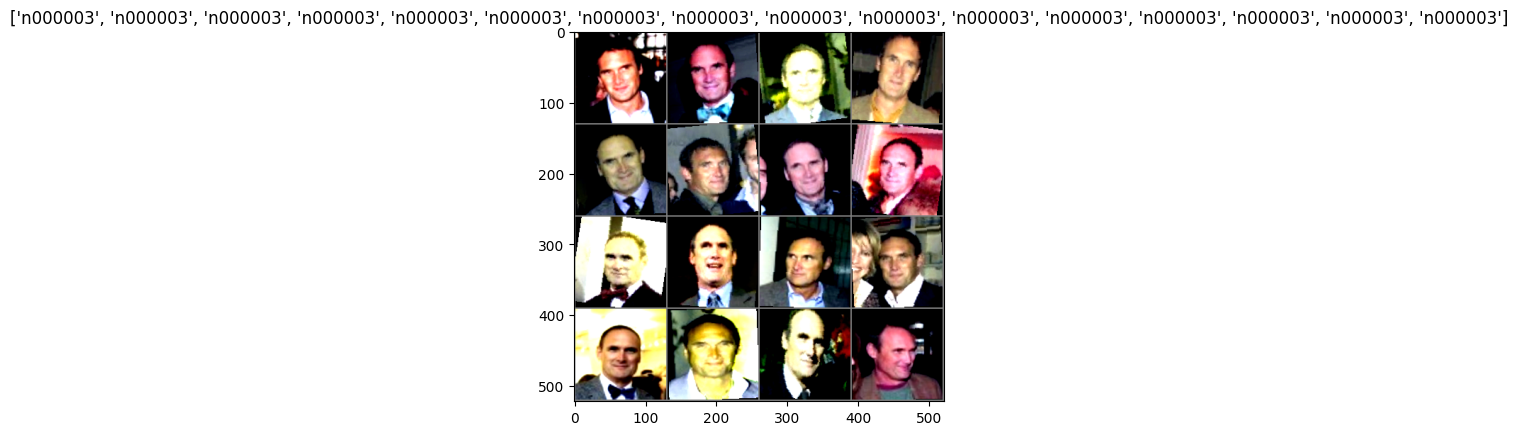

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to unnormalize and display images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Undo normalization to [0,1] range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Load a single batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display images in a 4x4 grid
imshow(torchvision.utils.make_grid(images[:16], nrow=4), title=[train_dataset.classes[label] for label in labels[:16]])

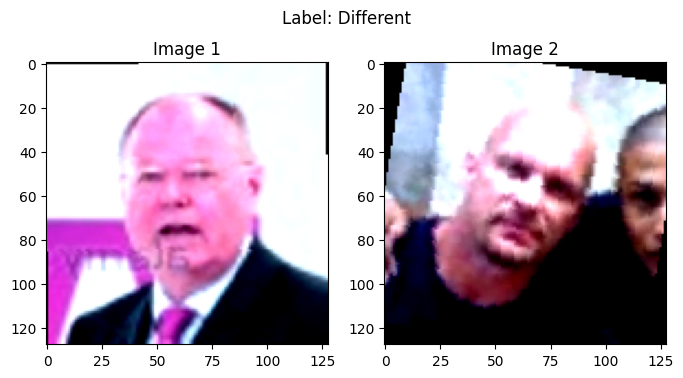

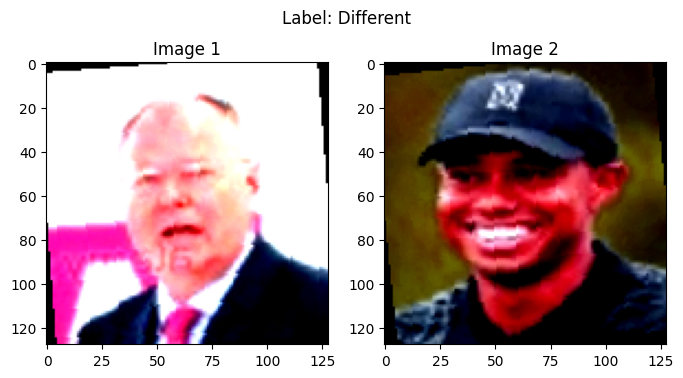

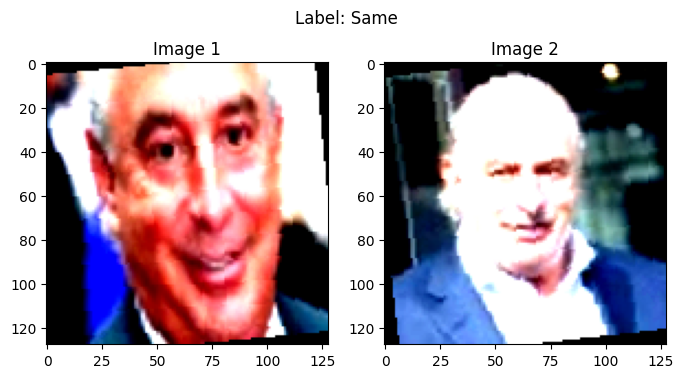

In [6]:
def show_verification_pairs(img1, img2, label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Display the first image
    img1 = img1 / 2 + 0.5  # Unnormalize
    npimg1 = img1.numpy()
    axes[0].imshow(np.transpose(npimg1, (1, 2, 0)))
    axes[0].set_title("Image 1")

    # Display the second image
    img2 = img2 / 2 + 0.5  # Unnormalize
    npimg2 = img2.numpy()
    axes[1].imshow(np.transpose(npimg2, (1, 2, 0)))
    axes[1].set_title("Image 2")

    # Display the label
    fig.suptitle(f"Label: {'Same' if label == 1 else 'Different'}")
    plt.show()

# Load a few pairs from the verification_loader
verification_iter = iter(verification_loader)
for _ in range(3):  # Display 3 pairs
    img1_batch, img2_batch, labels = next(verification_iter)
    show_verification_pairs(img1_batch[0], img2_batch[0], labels[0].item())

# **3. VERIFICATION MODEL**

## **1. BUILD MODEL**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 16 * 16, 256)  
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x


In [14]:
import torch
import torch.nn as nn

class TripletNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, anchor, positive, negative):
        # Generate embeddings for each input
        anchor_embedding = self.embedding_net(anchor)
        positive_embedding = self.embedding_net(positive)
        negative_embedding = self.embedding_net(negative)
        return anchor_embedding, positive_embedding, negative_embedding

In [15]:
import torch
import torch.nn.functional as F

# Define the triplet loss function
def triplet_loss_fn(anchor, positive, negative, margin=1.0):
    positive_dist = F.pairwise_distance(anchor, positive, p=2)
    negative_dist = F.pairwise_distance(anchor, negative, p=2)
    loss = torch.relu(positive_dist - negative_dist + margin)
    return loss.mean()

In [ ]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

class TripletDataset(Dataset):
    """
    Custom Dataset to generate triplets (anchor, positive, negative) with labels for training.
    """
    def __init__(self, image_folder_dataset, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.data = image_folder_dataset.imgs  # List of (image_path, label)
        self.labels = image_folder_dataset.targets  # Corresponding labels
        self.class_to_idx = self._build_class_to_idx()
        self.transform = transform or image_folder_dataset.transform

        # Ensure there are no empty classes
        if any(len(indices) < 2 for indices in self.class_to_idx.values()):
            raise ValueError("All classes must have at least two samples for triplet generation.")
    
    def _build_class_to_idx(self):
        """Build a dictionary mapping class labels to the indices of their images."""
        class_to_idx = {}
        for idx, (_, label) in enumerate(self.data):
            class_to_idx.setdefault(label, []).append(idx)
        return class_to_idx
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        """Get a triplet: (anchor, positive, negative, label)."""
        anchor_path, anchor_label = self.data[index]
        
        # Positive sample (same class as anchor)
        positive_index = random.choice(self.class_to_idx[anchor_label])
        while positive_index == index:  # Avoid duplicate with anchor
            positive_index = random.choice(self.class_to_idx[anchor_label])
        positive_path, _ = self.data[positive_index]
        
        # Negative sample (different class)
        negative_label = random.choice(list(self.class_to_idx.keys()))
        while negative_label == anchor_label:  # Avoid same class as anchor
            negative_label = random.choice(list(self.class_to_idx.keys()))
        negative_index = random.choice(self.class_to_idx[negative_label])
        negative_path, _ = self.data[negative_index]
        
        # Load images
        anchor_img = self.image_folder_dataset.loader(anchor_path)
        positive_img = self.image_folder_dataset.loader(positive_path)
        negative_img = self.image_folder_dataset.loader(negative_path)
        
        # Apply transformations
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img, anchor_label



# Wrap train_dataset with TripletDataset
triplet_train_dataset = TripletDataset(train_dataset)

# Create DataLoader for triplet dataset
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=32, shuffle=True, num_workers=4)

triplet_iter = iter(triplet_train_loader)
anchors, positives, negatives, labels = next(triplet_iter)
print(f"Anchor batch shape: {anchors.shape}")
print(f"Positive batch shape: {positives.shape}")
print(f"Negative batch shape: {negatives.shape}")
print(f"Labels batch shape: {labels.shape}")

Anchor batch shape: torch.Size([32, 3, 128, 128])
Positive batch shape: torch.Size([32, 3, 128, 128])
Negative batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


## **2. TRAIN AND VALIDATE MODEL**

In [17]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0

    for batch in tqdm(dataloader, desc="Training", unit="batch"):
        anchors, positives, negatives, labels = [x.to(device) for x in batch]
        
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        anchor_out, positive_out, negative_out = model(anchors, positives, negatives)
        loss = criterion(anchor_out, positive_out, negative_out)

        # Backward pass and update
        loss.backward()
        optimizer.step()

        # Track loss
        epoch_loss += loss.item()

    # Average loss
    epoch_loss /= len(dataloader)
    return epoch_loss

def validate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in dataloader:
            img1, img2, labels = [x.to(device) for x in batch]

            # Forward pass to get the embeddings
            img1_embed = model.embedding_net(img1)
            img2_embed = model.embedding_net(img2)

            # Compute cosine similarity between the embeddings
            similarity = F.cosine_similarity(img1_embed, img2_embed)

            # Store labels and similarity scores for AUC calculation
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(similarity.cpu().numpy())

    # Compute AUC
    auc = roc_auc_score(all_labels, all_scores)
    return {"AUC": auc}


In [ ]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path, device
):
    best_auc = 0.0
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation phase
        metrics = validate(model, val_loader, device)
        print(f"Validation AUC: {metrics['AUC']:.4f}")

        # Save the best model
        if metrics["AUC"] > best_auc:
            best_auc = metrics["AUC"]
            torch.save(model, save_path)  # Save the entire model
            print(f"Best model saved at {save_path}")

        # Adjust learning rate
        scheduler.step()

    print(f"\nTraining complete. Best Validation AUC: {best_auc:.4f}")
    
    # Save the final model after training is complete
    final_model_path = save_path.replace(".pth", "_final.pth")
    torch.save(model, final_model_path)  # Save the entire model
    print(f"Final model saved at {final_model_path}")

# Initialize the components
embedding_net = EmbeddingNet() 
model = TripletNetwork(embedding_net).to(device)

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Set the training parameters
num_epochs = 15
save_path = "./best_triplet_network.pth"

# Train and validate the model
train_and_validate(model, triplet_train_loader, verification_loader, triplet_loss_fn, optimizer, num_epochs, save_path, device)



Epoch 1/15


Training: 100%|██████████| 11895/11895 [37:05<00:00,  5.35batch/s]


Train Loss: 0.4683
Validation AUC: 0.7681
Best model saved at ./best_triplet_network.pth

Epoch 2/15


Training: 100%|██████████| 11895/11895 [34:21<00:00,  5.77batch/s]

Train Loss: 0.3428


Validation AUC: 0.7900
Best model saved at ./best_triplet_network.pth

Epoch 3/15


Training: 100%|██████████| 11895/11895 [34:12<00:00,  5.79batch/s]

Train Loss: 0.3016


Validation AUC: 0.7952
Best model saved at ./best_triplet_network.pth

Epoch 4/15


Training: 100%|██████████| 11895/11895 [33:55<00:00,  5.84batch/s]

Train Loss: 0.2745


Validation AUC: 0.7993
Best model saved at ./best_triplet_network.pth

Epoch 5/15


Training: 100%|██████████| 11895/11895 [34:22<00:00,  5.77batch/s]

Train Loss: 0.2548


Validation AUC: 0.8098
Best model saved at ./best_triplet_network.pth

Epoch 6/15


Training: 100%|██████████| 11895/11895 [35:05<00:00,  5.65batch/s]

Train Loss: 0.2273


Validation AUC: 0.8122
Best model saved at ./best_triplet_network.pth

Epoch 7/15


Training: 100%|██████████| 11895/11895 [34:33<00:00,  5.74batch/s]

Train Loss: 0.2162


Validation AUC: 0.8073

Epoch 8/15


Training: 100%|██████████| 11895/11895 [34:24<00:00,  5.76batch/s]

Train Loss: 0.2084


Validation AUC: 0.8226
Best model saved at ./best_triplet_network.pth

Epoch 9/15


Training: 100%|██████████| 11895/11895 [34:37<00:00,  5.72batch/s]

Train Loss: 0.2007


Validation AUC: 0.8205

Epoch 10/15


Training: 100%|██████████| 11895/11895 [34:41<00:00,  5.71batch/s]

Train Loss: 0.1974


Validation AUC: 0.8249
Best model saved at ./best_triplet_network.pth

Epoch 11/15


Training: 100%|██████████| 11895/11895 [34:40<00:00,  5.72batch/s]

Train Loss: 0.1854


Validation AUC: 0.8318
Best model saved at ./best_triplet_network.pth

Epoch 12/15


Training: 100%|██████████| 11895/11895 [33:58<00:00,  5.84batch/s]

Train Loss: 0.1806


Validation AUC: 0.8201

Epoch 13/15


Training: 100%|██████████| 11895/11895 [34:16<00:00,  5.79batch/s]

Train Loss: 0.1765


Validation AUC: 0.8292

Epoch 14/15


Training: 100%|██████████| 11895/11895 [34:41<00:00,  5.71batch/s]

Train Loss: 0.1740


Validation AUC: 0.8354
Best model saved at ./best_triplet_network.pth

Epoch 15/15


Training: 100%|██████████| 11895/11895 [34:26<00:00,  5.76batch/s]

Train Loss: 0.1725


Validation AUC: 0.8389
Best model saved at ./best_triplet_network.pth

Training complete. Best Validation AUC: 0.8389
Final model saved at ./best_triplet_network_final.pth
